In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [87]:
data_folder = 'data/'
data_file = '10101.csv'

In [88]:
df = pd.read_csv(data_folder + data_file)
df["time"] = df.index
df["day"] = df["time"] // 21600

# mapping = {'w': 0, 'n': 1, 'r': 2}
# df["state"] = df["state"].replace(mapping)

# keep only day 0
df = df[df["day"] == 0]
df["state"].value_counts()

w    11680
n     9104
r      816
Name: state, dtype: int64

In [91]:
df1 = df.copy()
df1 = df1.drop(["rawState", "temp", "time", "day"], axis=1)

import tensorflow as tf

num_classes = df["state"].unique().shape[0]

x = df1.drop(["state"], axis=1)
y_raw = df1["state"]

In [117]:
from sklearn.preprocessing import LabelEncoder

# encoder = LabelEncoder()
# encoder.fit(Y)
# Y = encoder.transform(Y)
# Y = np_utils.to_categorical(Y)

le = LabelEncoder()
le.fit(y_raw)
y = le.transform(y_raw)
print(le.classes_)

y = tf.keras.utils.to_categorical(y)

['n' 'r' 'w']


In [93]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=13)

In [94]:
# Scale on train, or whole data?
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [95]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

In [149]:
def baseline_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(16, input_dim=input_dim, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    return model

model = baseline_model(x_train.shape[1], le.classes_.size)
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 16)                48        
                                                                 
 dense_41 (Dense)            (None, 8)                 136       
                                                                 
 dense_42 (Dense)            (None, 3)                 27        
                                                                 
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


In [148]:
def plot_loss(history):
    fig, ax = plt.subplots(1, 1)    
    ax.plot(history['loss'])
    ax.plot(history['val_loss'])
    ax.set_title('Model loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(['train', 'test'], loc='upper right')

In [126]:
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_test, y_test),
                    epochs=25,
                    batch_size=10,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1)]
                )

plot_loss(history.history)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [135]:
from sklearn.metrics import classification_report, confusion_matrix
# cm = np.array(confusion_matrix(y_test, y_predict, labels=[0,-1,1], normalize='pred'))
# confusion = pd.DataFrame(cm, index=['Wake', 'Non-Rem', 'Rem'], columns=['P Wake', 'P Non-Rem', 'P Rem'])
# confusion

y_pred = model.predict(x_test)
y_pred1 = np.argmax(y_pred, axis=1)

# list and count of values
# y_pred = le.inverse_transform(y_pred)
# print(np.unique(y_pred, return_counts=True))
y_pred1

135/135 [==============================] - 0s 2ms/step


array([2, 2, 2, ..., 0, 0, 0])

In [136]:
# confusion matrix
y_test1 = np.argmax(y_test, axis=1)
y_test1

array([2, 2, 0, ..., 0, 0, 0])

In [144]:
# confusion matrix
cm = confusion_matrix(y_test1, y_pred1)
cm

array([[1713,   31,   55],
       [  78,   32,   55],
       [  66,   39, 2251]])

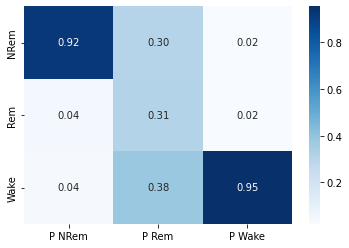

In [147]:
# seaborn confusion matrix ratio
cm = np.array(confusion_matrix(y_test1, y_pred1, labels=[0,1,2], normalize='pred'))
confusion = pd.DataFrame(cm, index=['NRem', 'Rem', 'Wake'], columns=['P NRem', 'P Rem', 'P Wake'])
sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
plt.show()